## 5G 데이터 구매고객 RFM 만들어보기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

In [ ]:
df = pd.read_parquet("df_smartphone.gzip")
df.head()

In [ ]:
df.info()

In [ ]:
# 결측치 제거 후 확인
df = df.dropna()
df.isnull().sum()

In [ ]:
df.shape

In [ ]:
# event_time을 datatime으로 변경
df["event_time"] = pd.to_datetime(df["event_time"])
df.info()

In [ ]:
# downcast로 용량 줄이기
df['event_type'] = df['event_type'].astype('category')
df['product_id'] = df['product_id'].astype('uint64')
df['user_id'] = df['user_id'].astype('uint64')
df.info()

In [ ]:
# parquet로 저장하여 용량 줄이기
df.to_parquet("df_smartphone_5G.gzip", compression='gzip')

In [3]:
# 다시 불러오기
df = pd.read_parquet("df_smartphone_5G.gzip")

In [4]:
print(df.shape)
df.info()

(11466744, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11466744 entries, 0 to 11507230
Data columns (total 7 columns):
 #   Column        Dtype              
---  ------        -----              
 0   event_time    datetime64[ns, UTC]
 1   event_type    category           
 2   product_id    uint64             
 3   brand         object             
 4   price         float64            
 5   user_id       uint64             
 6   user_session  object             
dtypes: category(1), datetime64[ns, UTC](1), float64(1), object(2), uint64(2)
memory usage: 623.3+ MB


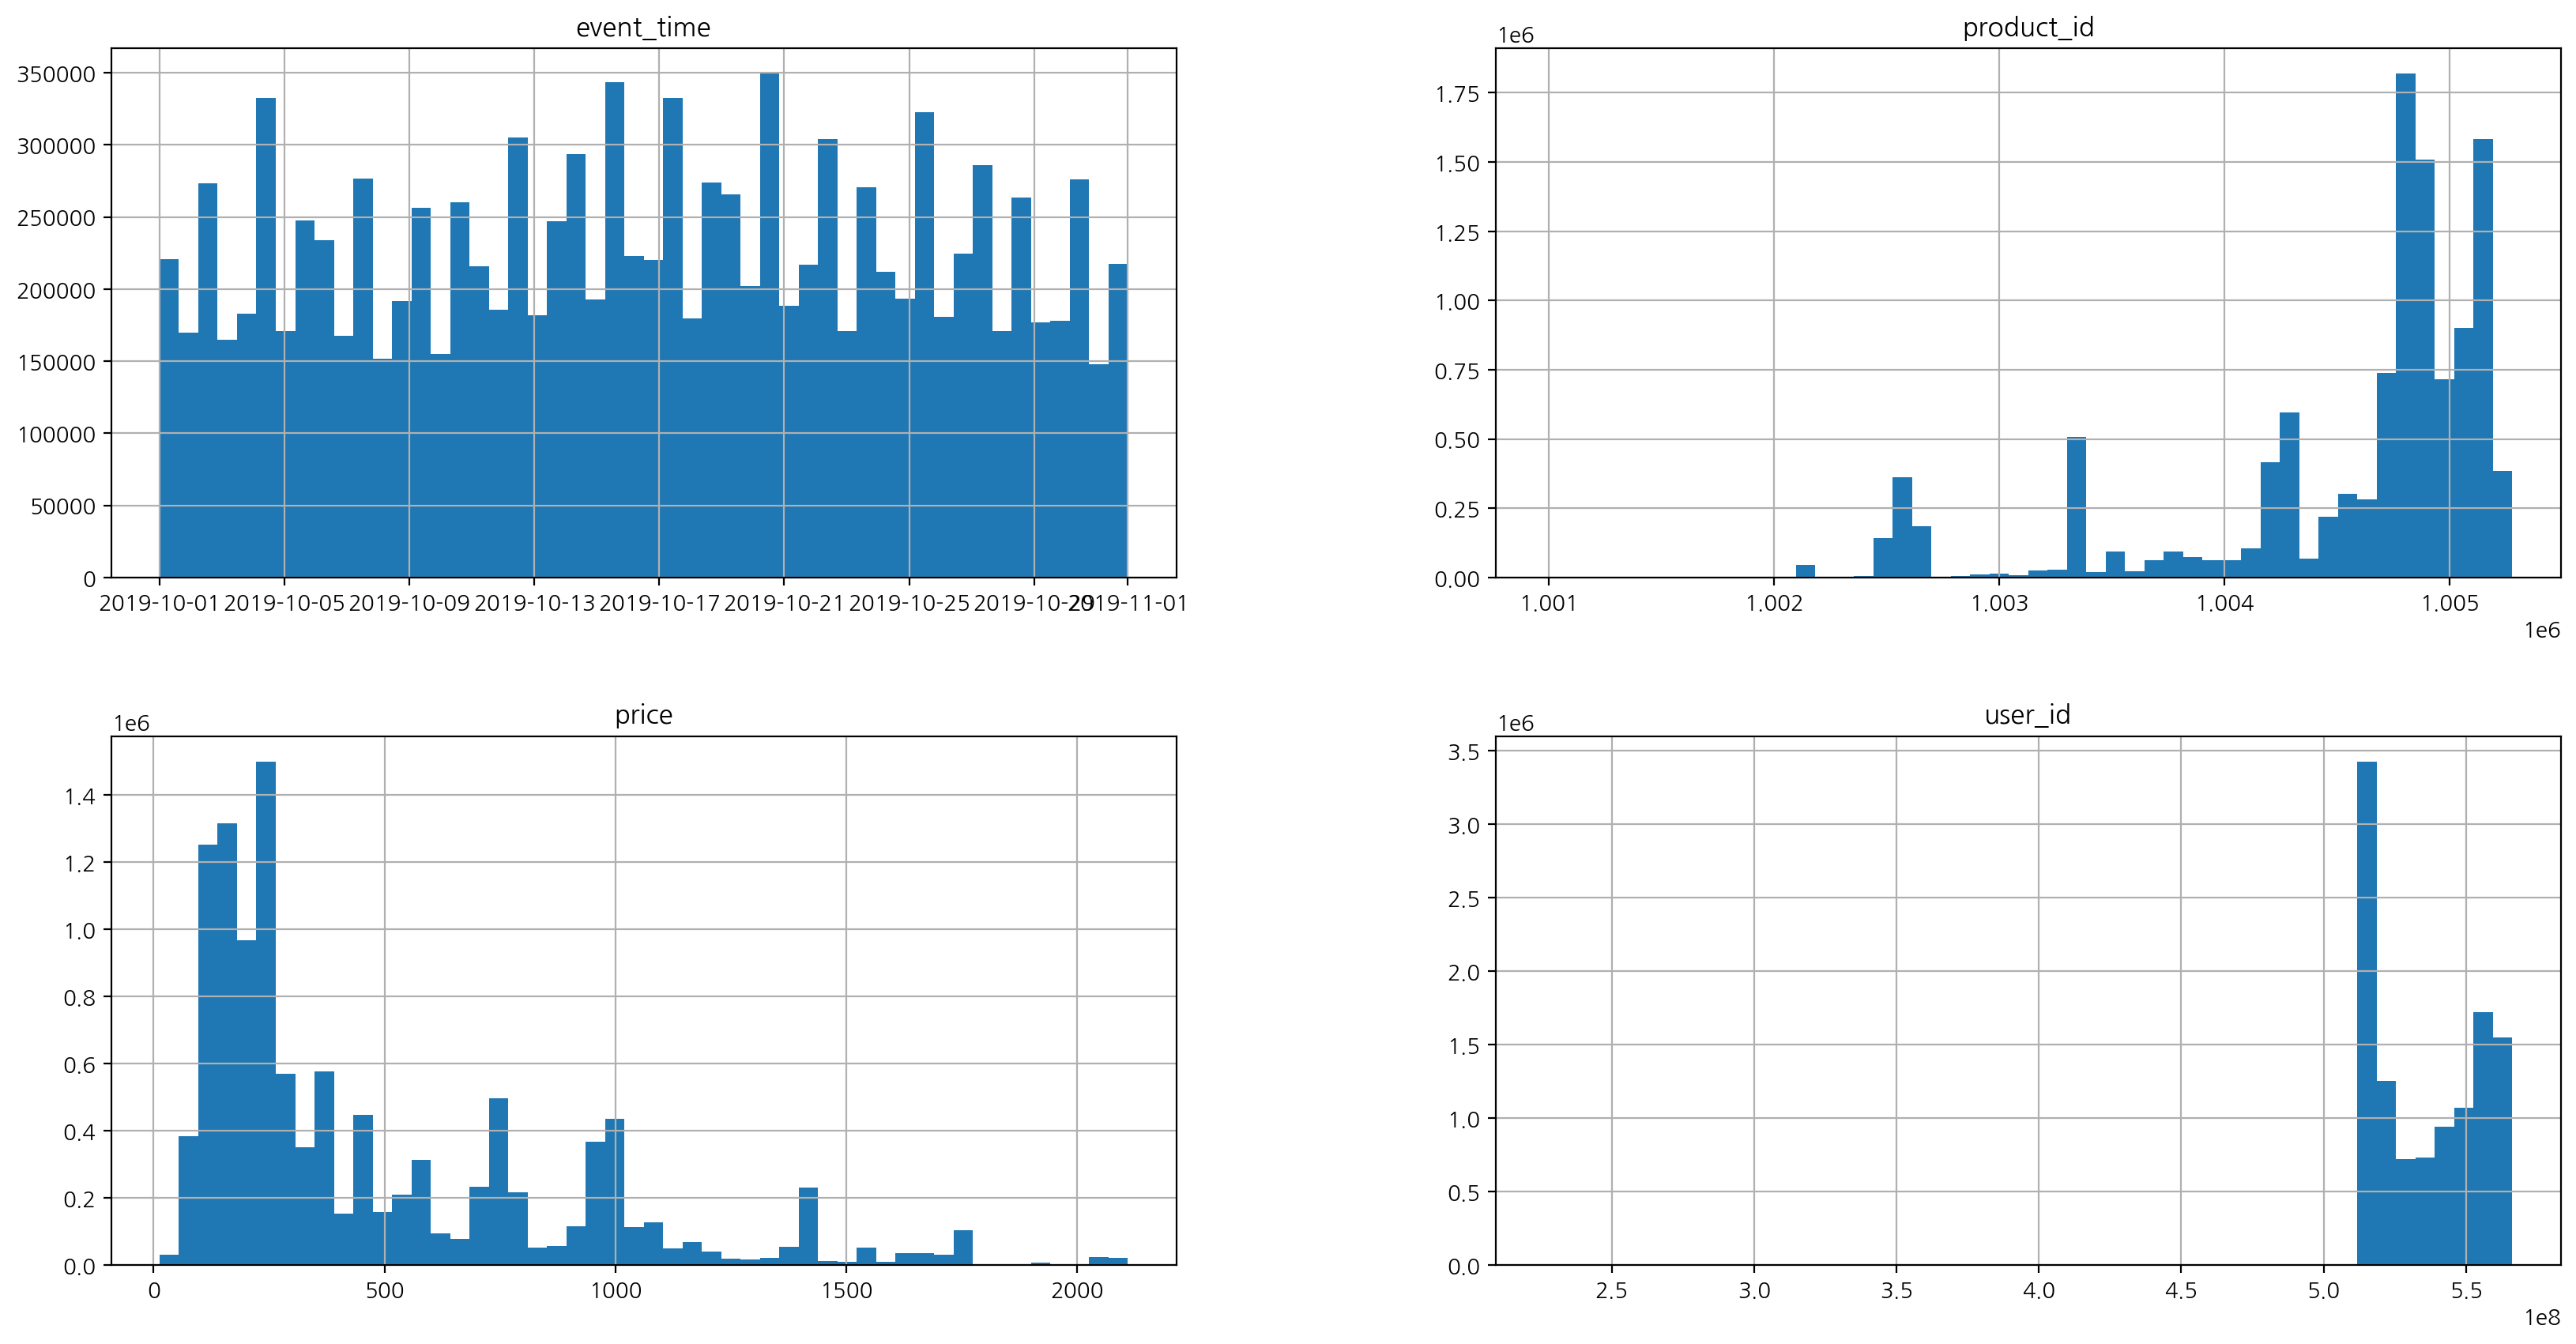

In [5]:
df.hist(bins=50, figsize=(20,10));

In [6]:
# 중복 데이터 확인
df[df.duplicated(keep=False)].sort_values(["user_id"]).head(5)

,event_time,event_type,product_id,brand,price,user_id,user_session


In [ ]:
# 중복 데이터 제거 drop_duplicates
# 깊은 복사
df_sp = df.drop_duplicates().copy()
df_sp.shape

In [ ]:
# 중복 제거된 데이터 파일 저장
df_sp.to_parquet("df_smartphone_5G.gzip", compression='gzip')

## RFM
- Recency - 거래의 최근성: 고객이 얼마나 최근에 구입했는가?
- Frequency - 거래빈도: 고객이 얼마나 빈번하게 우리 상품을 구입했나?
- Monetary - 거래규모: 고객이 구입했던 총 금액은 어느 정도인가?

In [7]:
# RFM 만들 때 필요한 컬럼..?
df_sample = df[["event_time", "event_type", "price", "user_id"]]
df_sample.head()

,event_time,event_type,price,user_id
0,2019-10-01 00:00:04+00:00,view,1081.98,535871217
1,2019-10-01 00:00:11+00:00,view,566.01,537918940
2,2019-10-01 00:00:11+00:00,view,900.64,530282093
3,2019-10-01 00:00:19+00:00,view,1747.79,535871217
4,2019-10-01 00:00:20+00:00,view,588.77,555446831


In [8]:
df_sample["event_type"].unique()

['view', 'purchase', 'cart']
Categories (3, object): ['cart', 'purchase', 'view']

In [9]:
# 구매한 고객만 추출하기
df_pc = df_sample[df_sample["event_type"] == 'purchase']
df_pc = df_pc.reset_index()
df_pc

,index,event_time,event_type,price,user_id
0,48,2019-10-01 00:02:14+00:00,purchase,130.76,543272936
1,84,2019-10-01 00:04:37+00:00,purchase,642.69,551377651
2,162,2019-10-01 00:10:08+00:00,purchase,515.67,524325294
3,218,2019-10-01 00:14:14+00:00,purchase,463.31,555083442
4,469,2019-10-01 02:19:10+00:00,purchase,736.18,515246296
...,...,...,...,...,...
337531,11506944,2019-10-31 23:49:32+00:00,purchase,531.26,516662286
337532,11506968,2019-10-31 23:50:16+00:00,purchase,242.63,551781196
337533,11507072,2019-10-31 23:53:53+00:00,purchase,242.63,542774966
337534,11507135,2019-10-31 23:56:03+00:00,purchase,577.89,512717356


In [10]:
# 최근 주문일 구하기
last_timestamp = df_pc["event_time"].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:56:53+0000', tz='UTC')

In [11]:
df_pc = df_pc.drop("index", axis=1)
df_pc.head()

,event_time,event_type,price,user_id
0,2019-10-01 00:02:14+00:00,purchase,130.76,543272936
1,2019-10-01 00:04:37+00:00,purchase,642.69,551377651
2,2019-10-01 00:10:08+00:00,purchase,515.67,524325294
3,2019-10-01 00:14:14+00:00,purchase,463.31,555083442
4,2019-10-01 02:19:10+00:00,purchase,736.18,515246296


In [12]:
# 모두 구매한 사람들이니 필요없는 컬럼 삭제
df_pc = df_pc.drop("event_type", axis=1)
df_pc["user_id"].nunique()

160301

In [13]:
# 고객별 Recency, Frequency, Monetary 값 구하기
# Recency : 최근 거래 기준일(last_timestamp)과 고객별 최근 구매한 날짜(x.max())와 차이값
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
# 하나의 함수를 가지고 특정 행이나 데이터에만 동일하게 전처리를 해주고 싶을 때 Lambda를 사용해서 값을 계산할 수 있다
# 최근 마지막 거래일과 해당 고객의 마지막 거래일의 차이를 구하기 위하여 lambda 함수 사용한다.

RFM = df_pc.groupby("user_id").agg({"event_time" : lambda x : (last_timestamp - x.max()).days,
                                   "price":["count", "sum"]})
RFM.head()

event_time price        
            <lambda> count     sum
user_id                           
403013066         14     2  807.16
410333972          1     1  591.25
415873351          1     2  263.06
424869855          8     1   88.29
427391662         17     2  430.46

In [14]:
RFM.columns = ["Recency", "Frequency", "MonetaryValue"]
RFM

,Recency,Frequency,MonetaryValue
user_id,,,
403013066,14,2,807.16
410333972,1,1,591.25
415873351,1,2,263.06
424869855,8,1,88.29
427391662,17,2,430.46
...,...,...,...
566258816,1,1,128.42
566263549,1,1,275.25
566270060,1,1,88.29


In [15]:
RFM["Frequency"].value_counts()

1      102570
2       28570
3       11279
4        5745
5        3321
        ...  
101         1
144         1
99          1
110         1
86          1
Name: Frequency, Length: 114, dtype: int64

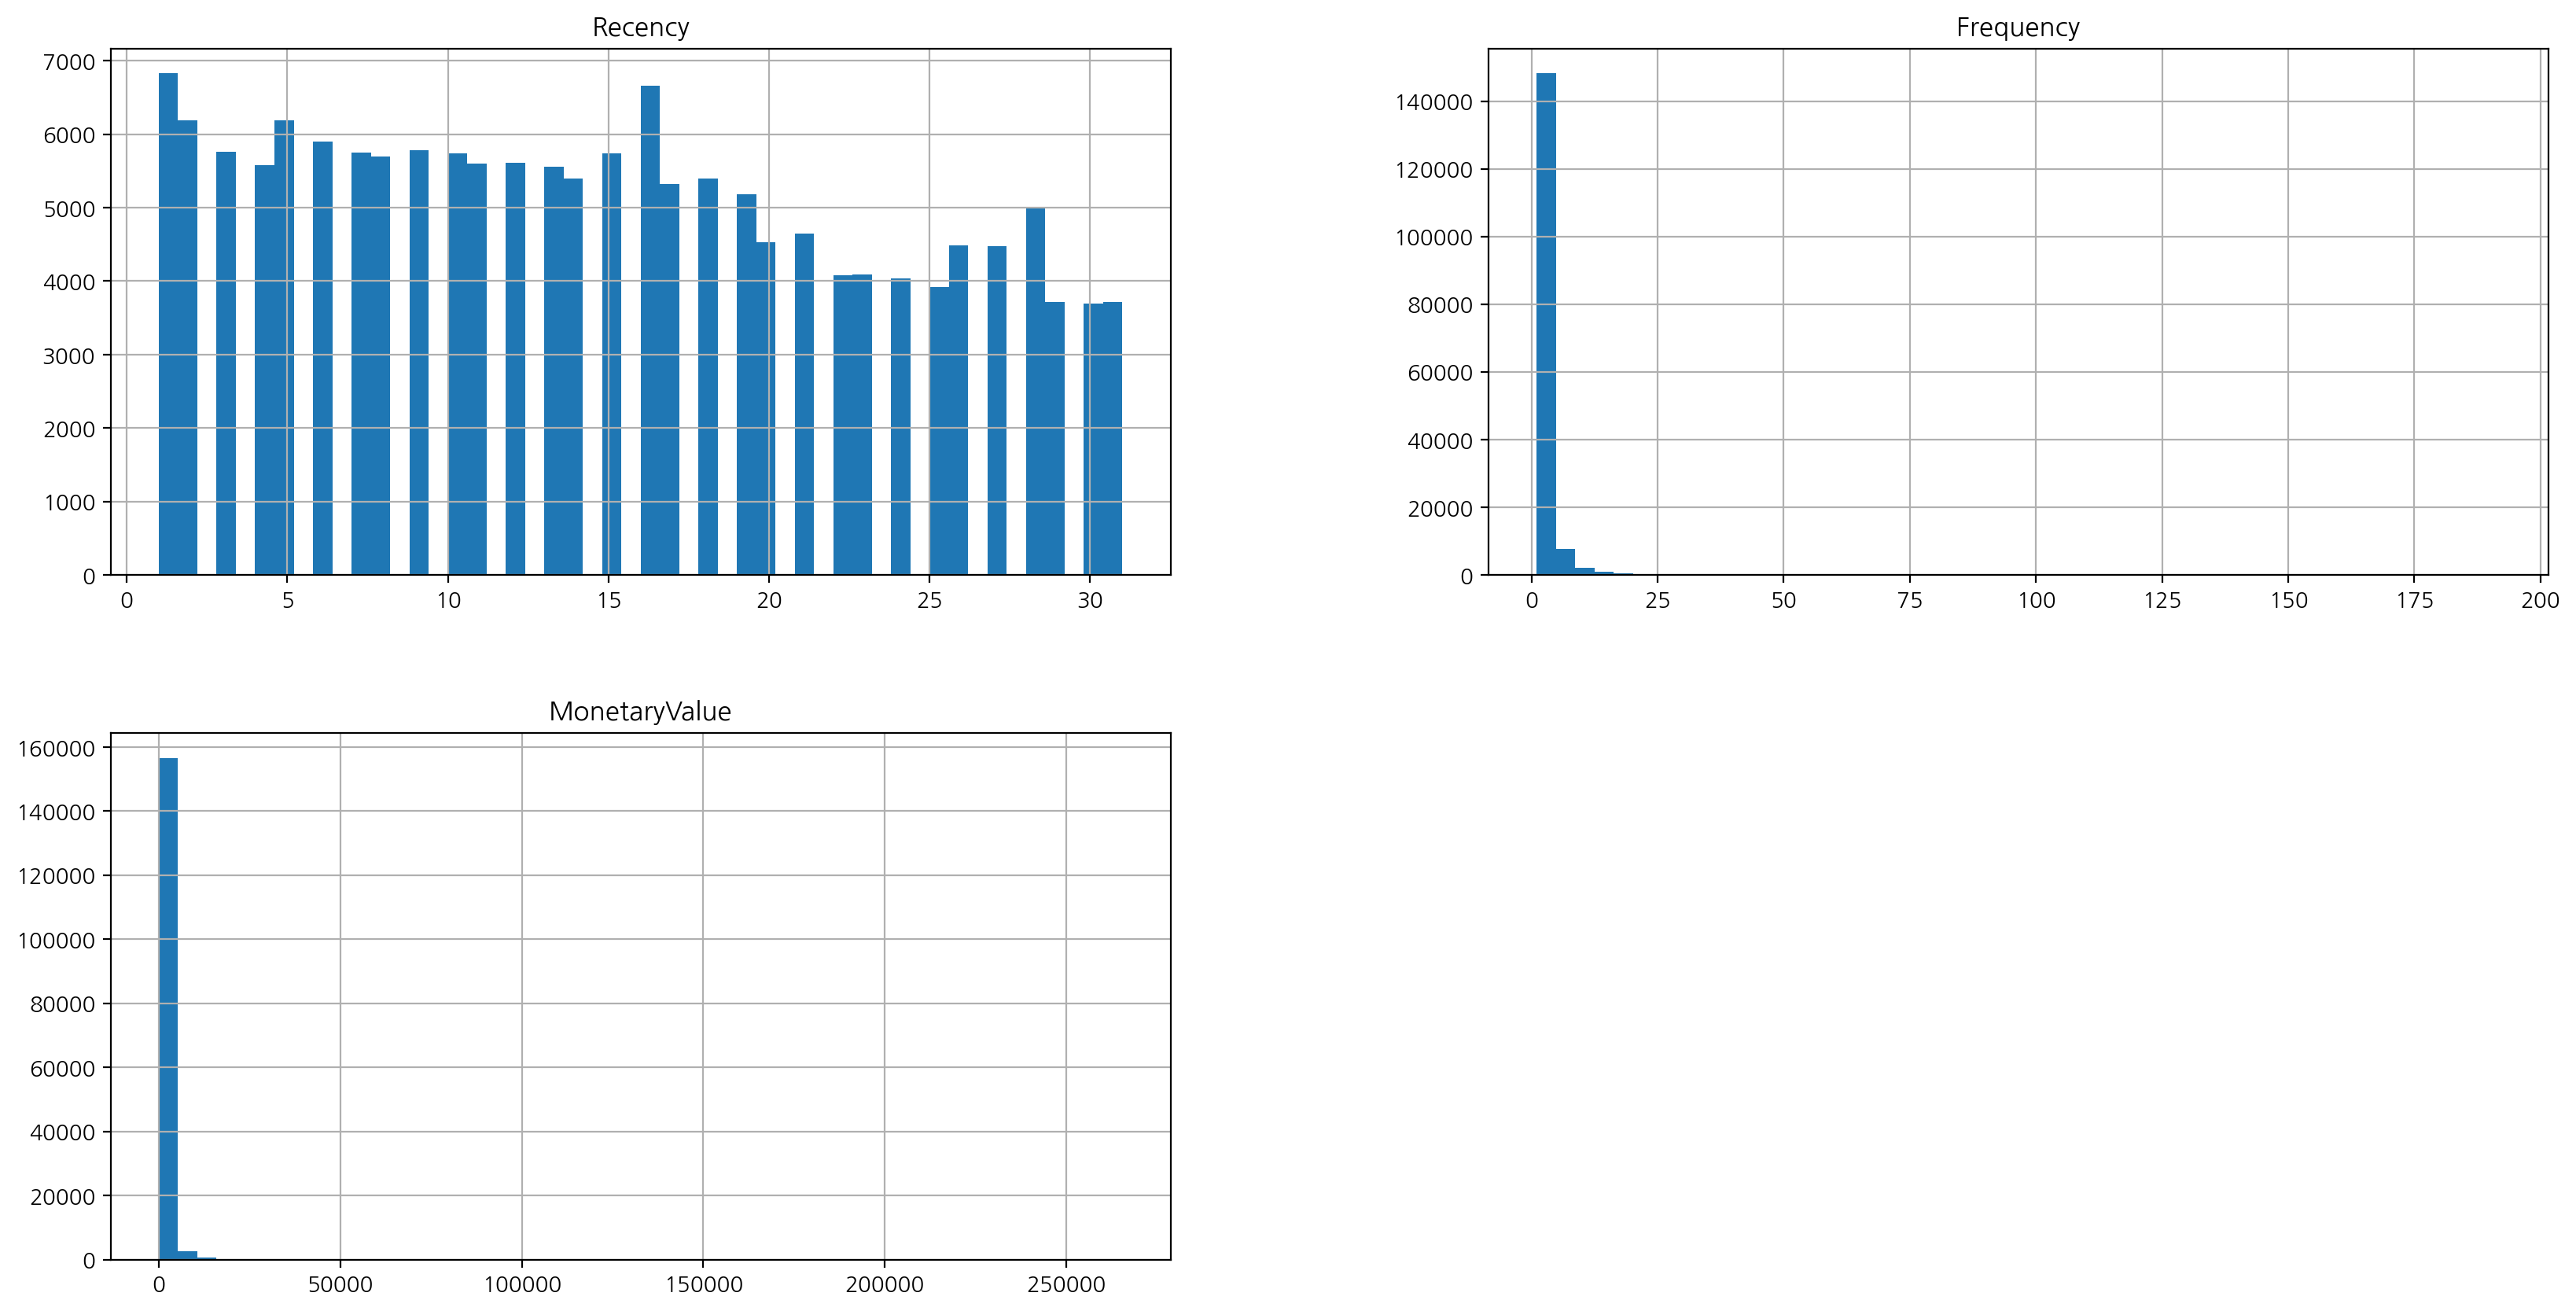

In [16]:
RFM.hist(bins=50, figsize=(20,10));

In [17]:
# qcut을 통한 RFM 변수 만들기
# Recency 는 최근일수록 높은 스코어
# Frequency, MonetaryValue 는 값이 클수록 높은 스코어
r_labels = list(range(3, 0, -1))
m_labels = list(range(1, 4))
cut_size = 3

r_cut = pd.qcut(RFM["Recency"], cut_size, labels=r_labels)
m_cut = pd.qcut(RFM["MonetaryValue"], cut_size, labels=m_labels)

In [18]:
print(RFM["Frequency"].min(), RFM["Frequency"].max())

1 192


In [19]:
f_edges = [0, 1, 3, 192]
f_labels = list(range(1,4))
f_cut = pd.cut(RFM["Frequency"], bins=f_edges, labels=f_labels)

In [20]:
RFM = RFM.assign(R=r_cut, F=f_cut, M=m_cut)
RFM 

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
403013066,14,2,807.16,2,2,3
410333972,1,1,591.25,3,1,2
415873351,1,2,263.06,3,2,2
424869855,8,1,88.29,3,1,1
427391662,17,2,430.46,2,2,2
...,...,...,...,...,...,...
566258816,1,1,128.42,3,1,1
566263549,1,1,275.25,3,1,2
566270060,1,1,88.29,3,1,1


In [21]:
# RFM_segment
RFM["RFM_segment"] = RFM["R"].astype(str) + RFM["F"].astype(str) + RFM["M"].astype(str)
RFM["RFM_segment"]

user_id
403013066    223
410333972    312
415873351    322
424869855    311
427391662    222
            ... 
566258816    311
566263549    312
566270060    311
566274637    313
566278294    313
Name: RFM_segment, Length: 160301, dtype: object

In [22]:
#  RFM Score
RFM["RFM_score"] = RFM[["R", "F", "M"]].sum(axis=1)
RFM

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
403013066,14,2,807.16,2,2,3,223,7
410333972,1,1,591.25,3,1,2,312,6
415873351,1,2,263.06,3,2,2,322,7
424869855,8,1,88.29,3,1,1,311,5
427391662,17,2,430.46,2,2,2,222,6
...,...,...,...,...,...,...,...,...
566258816,1,1,128.42,3,1,1,311,5
566263549,1,1,275.25,3,1,2,312,6
566270060,1,1,88.29,3,1,1,311,5


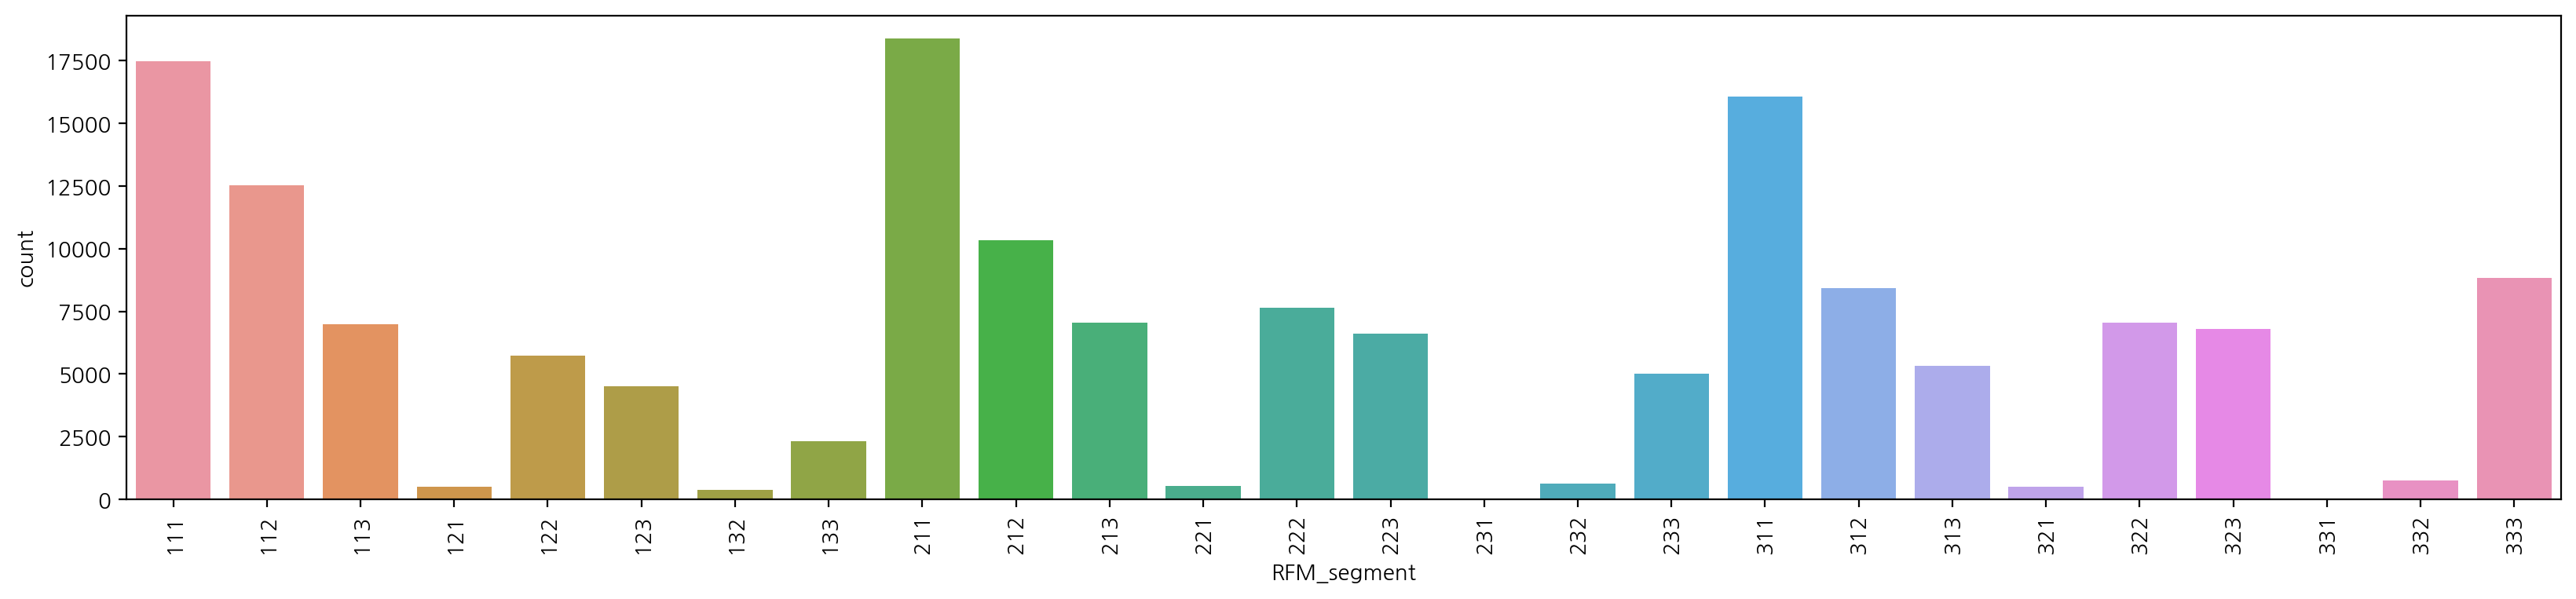

In [23]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.countplot(data=RFM.sort_values("RFM_segment"), x="RFM_segment");

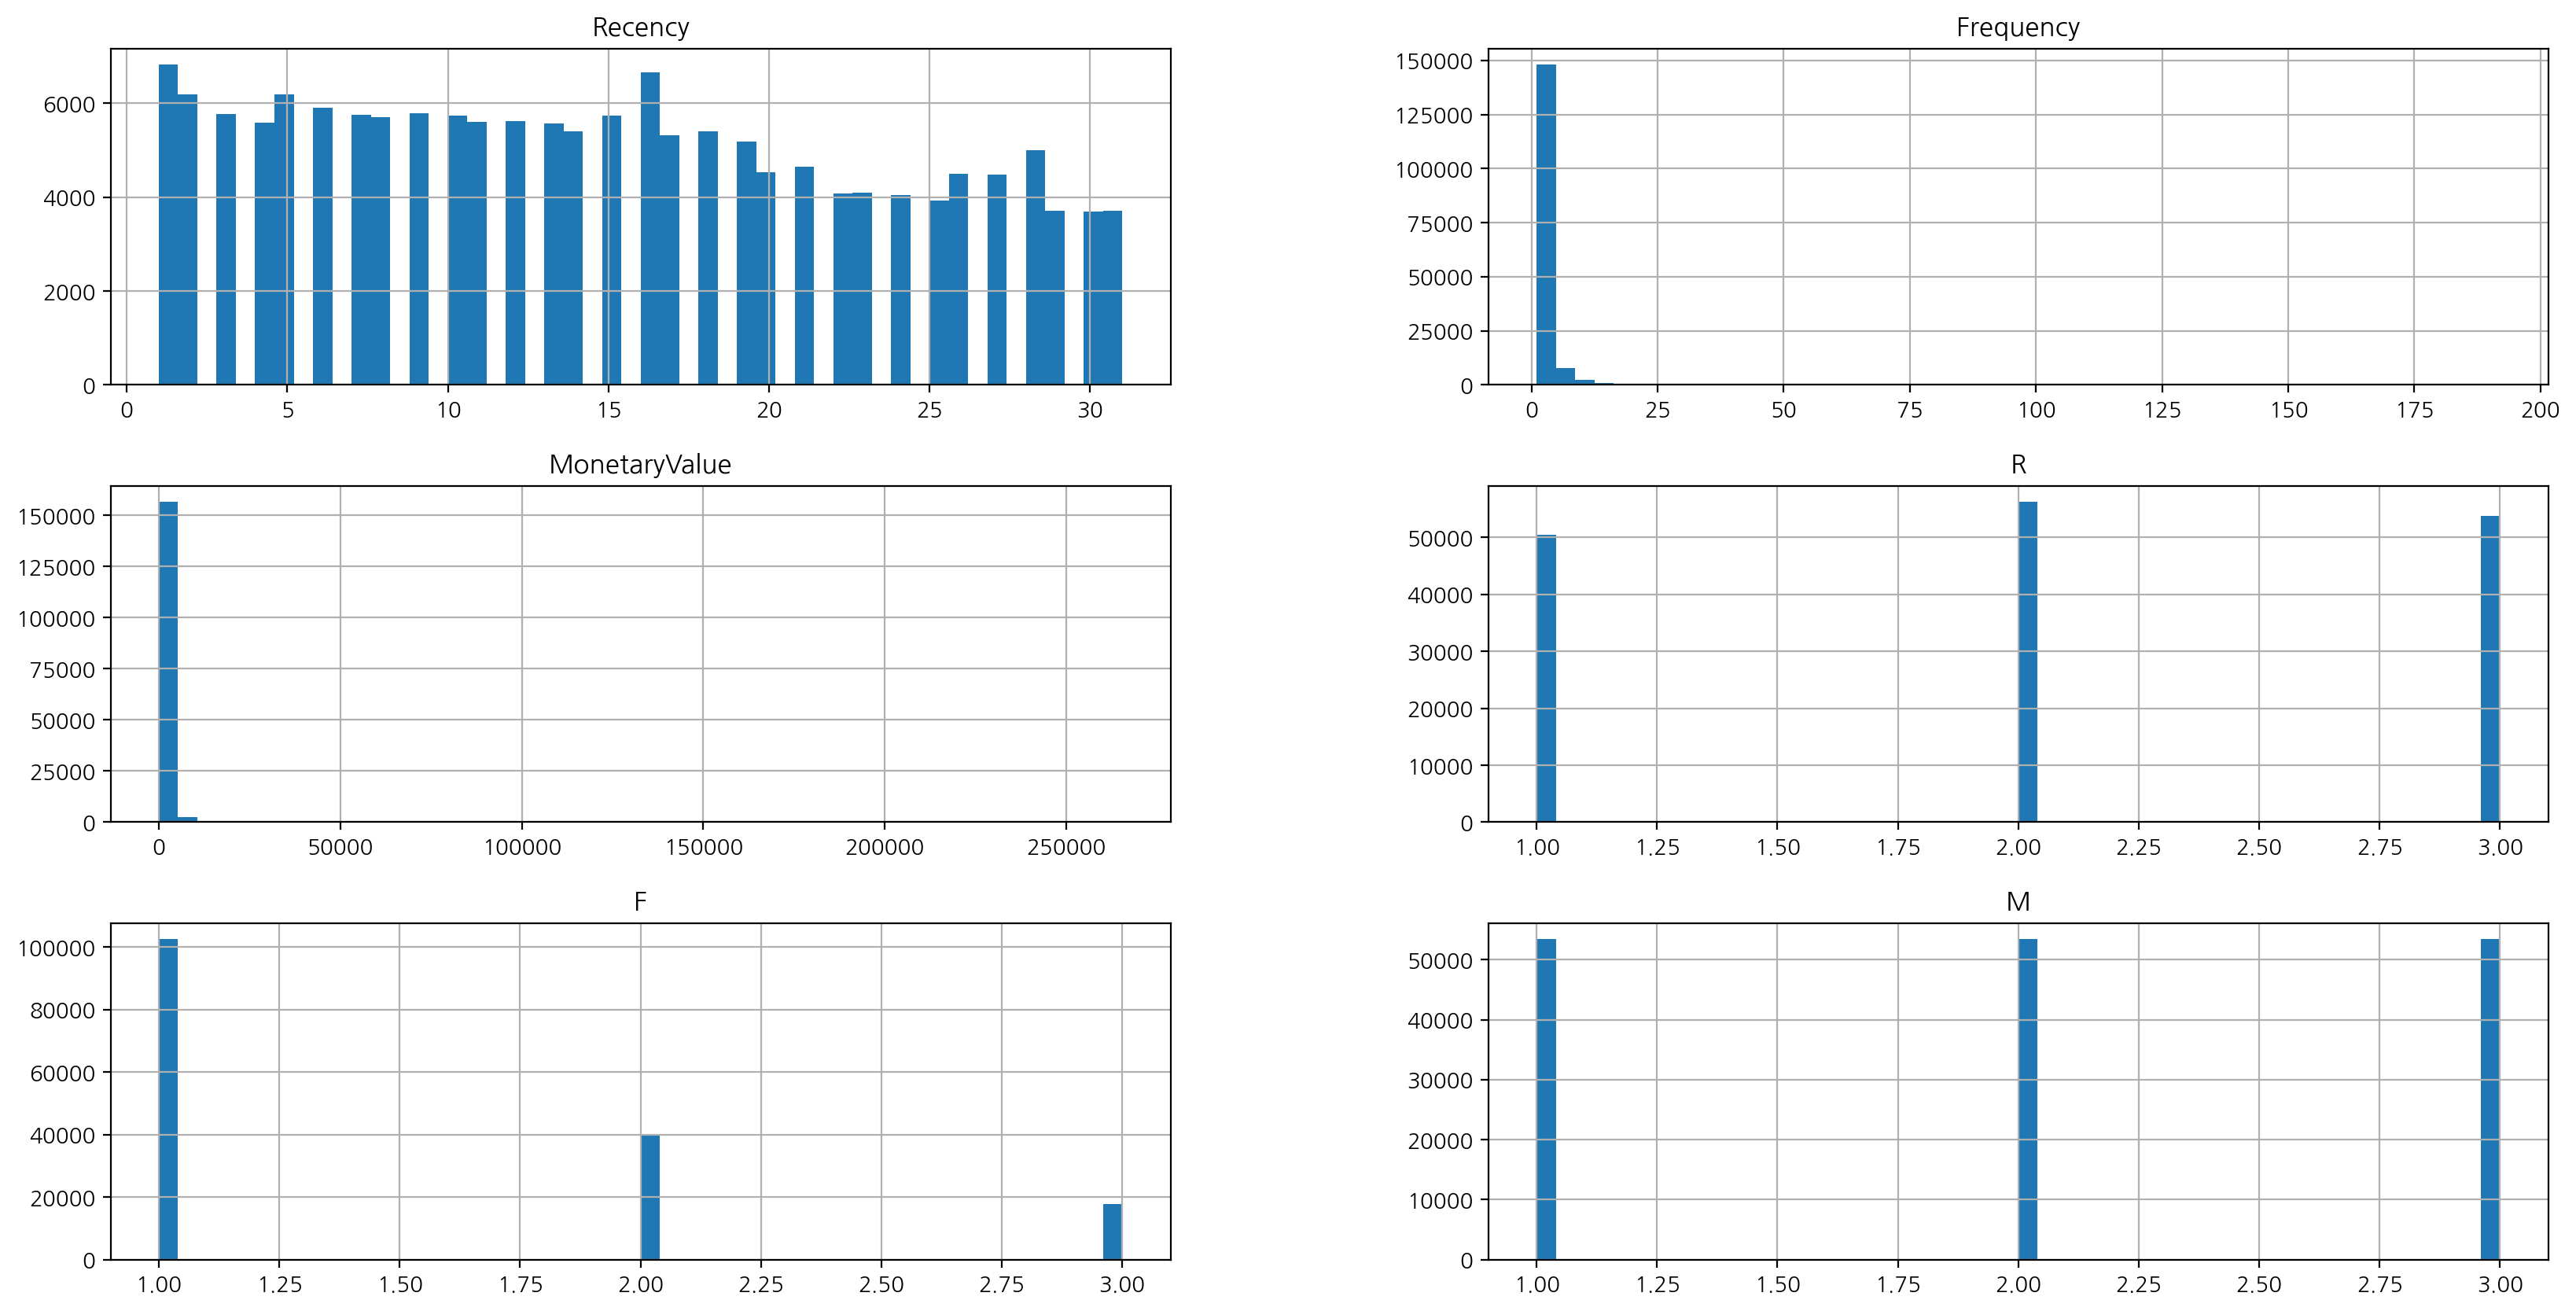

In [24]:
RFM.iloc[:, :-2].astype(float).hist(figsize=(20,10), bins=50);

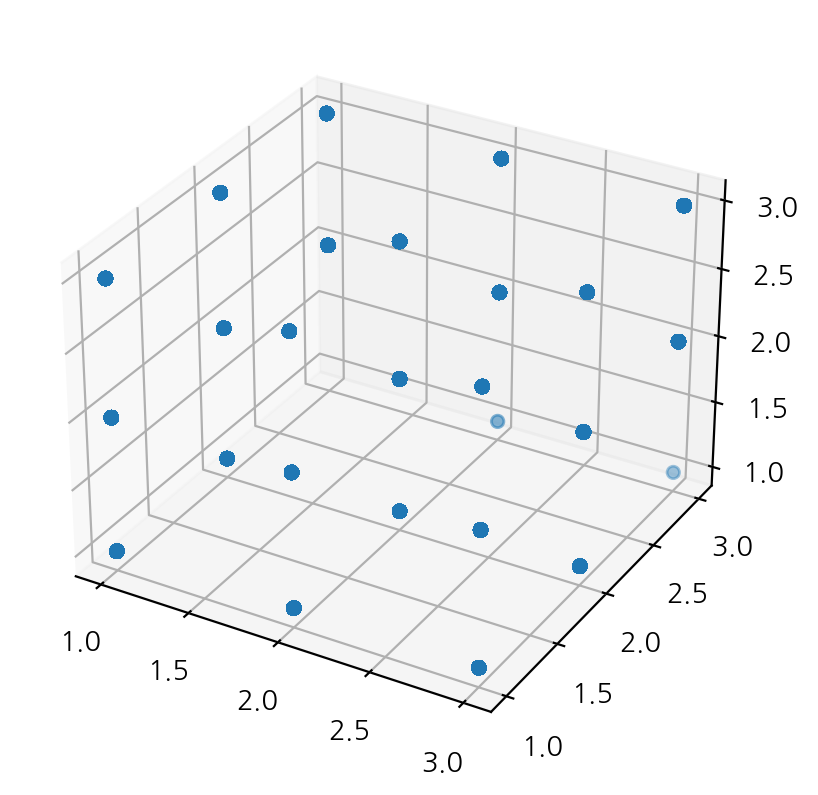

In [25]:
# 3d projection ax.scatter3D rfm["R"], rfm["F"], rfm["M"]
ax = plt.axes(projection='3d')
ax.scatter3D(RFM["R"], RFM["F"], RFM["M"]);

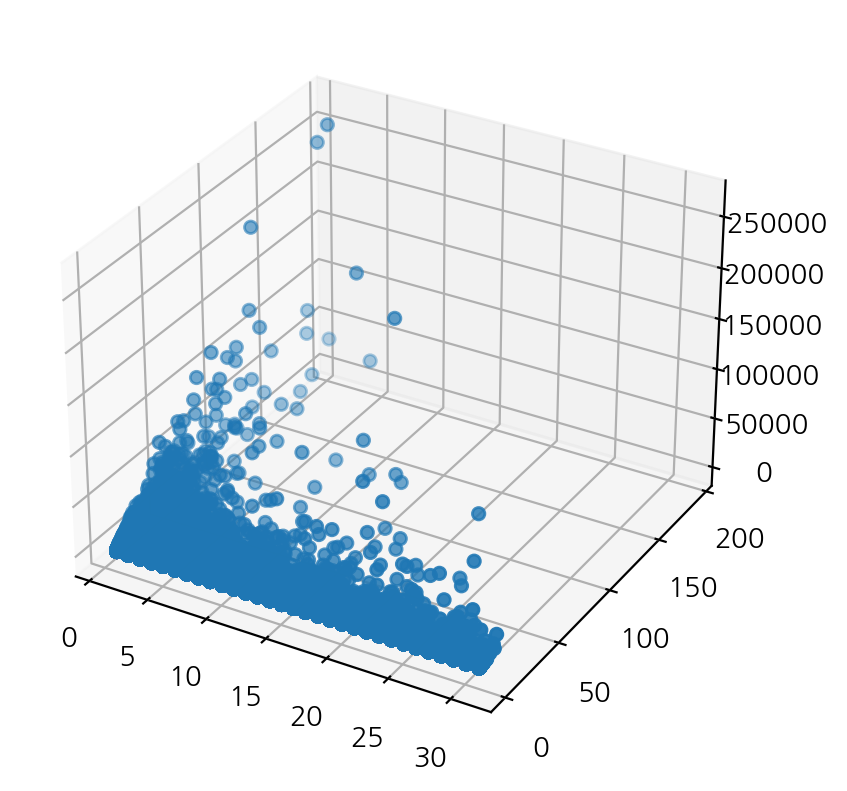

In [26]:
# rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"]
ax = plt.axes(projection='3d')
ax.scatter3D(RFM["Recency"], RFM["Frequency"], RFM["MonetaryValue"]);

In [27]:
rfm_sco = RFM.groupby("RFM_score").agg({"Recency":"mean", "Frequency":"mean", 
                                        "MonetaryValue":["mean", "sum"]}).style.format("{:,.0f}")
rfm_sco

In [28]:
rfm_sco.background_gradient()

In [29]:
labels = ["silver", "gold", "platinum"]
RFM["RFM_class"] = pd.qcut(RFM["RFM_score"], 3, labels)
RFM.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
403013066,14,2,807.16,2,2,3,223,7,platinum
410333972,1,1,591.25,3,1,2,312,6,gold
415873351,1,2,263.06,3,2,2,322,7,platinum
424869855,8,1,88.29,3,1,1,311,5,silver
427391662,17,2,430.46,2,2,2,222,6,gold


In [30]:
RFM.groupby("RFM_class")["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,88524.0,4.250203,0.763325,3.0,4.0,4.0,5.0,5.0
gold,28488.0,6.000000,0.000000,6.0,6.0,6.0,6.0,6.0
platinum,43289.0,7.697059,0.786648,7.0,7.0,7.0,8.0,9.0


<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

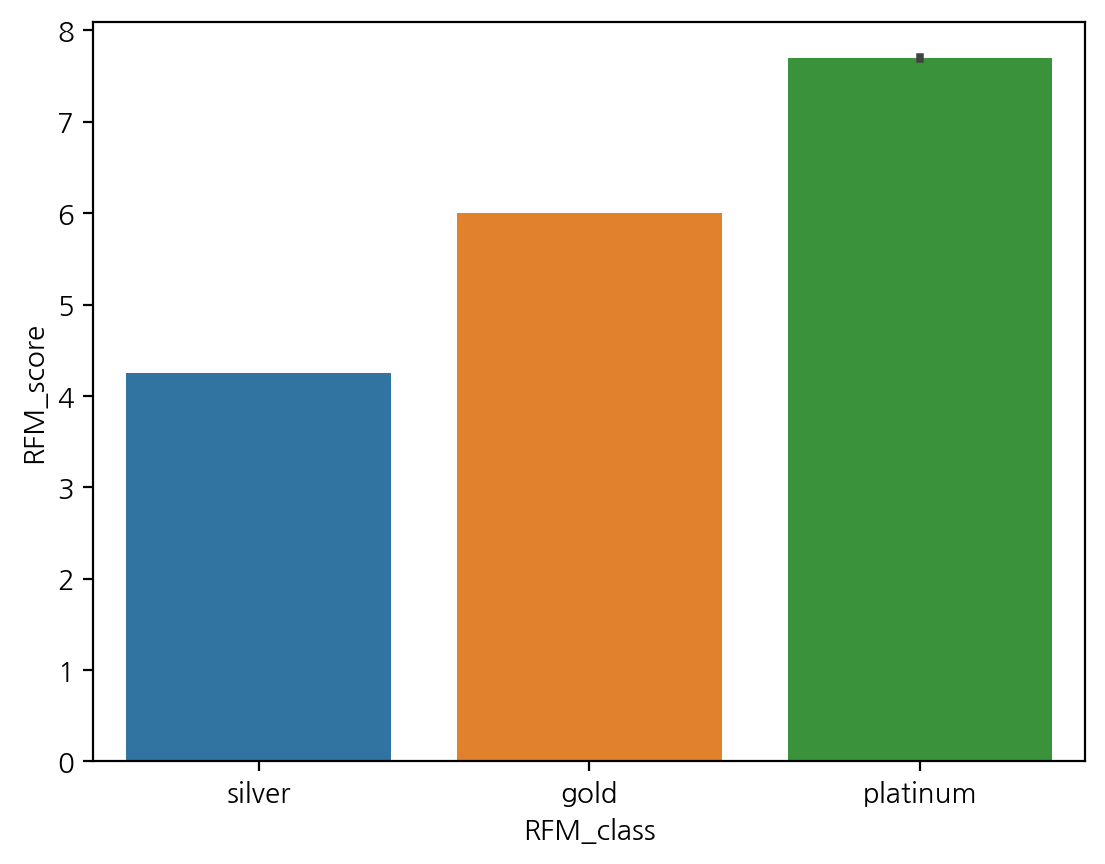

In [31]:
sns.barplot(data=RFM, x="RFM_class", y="RFM_score")

<AxesSubplot:xlabel='RFM_class', ylabel='RFM_score'>

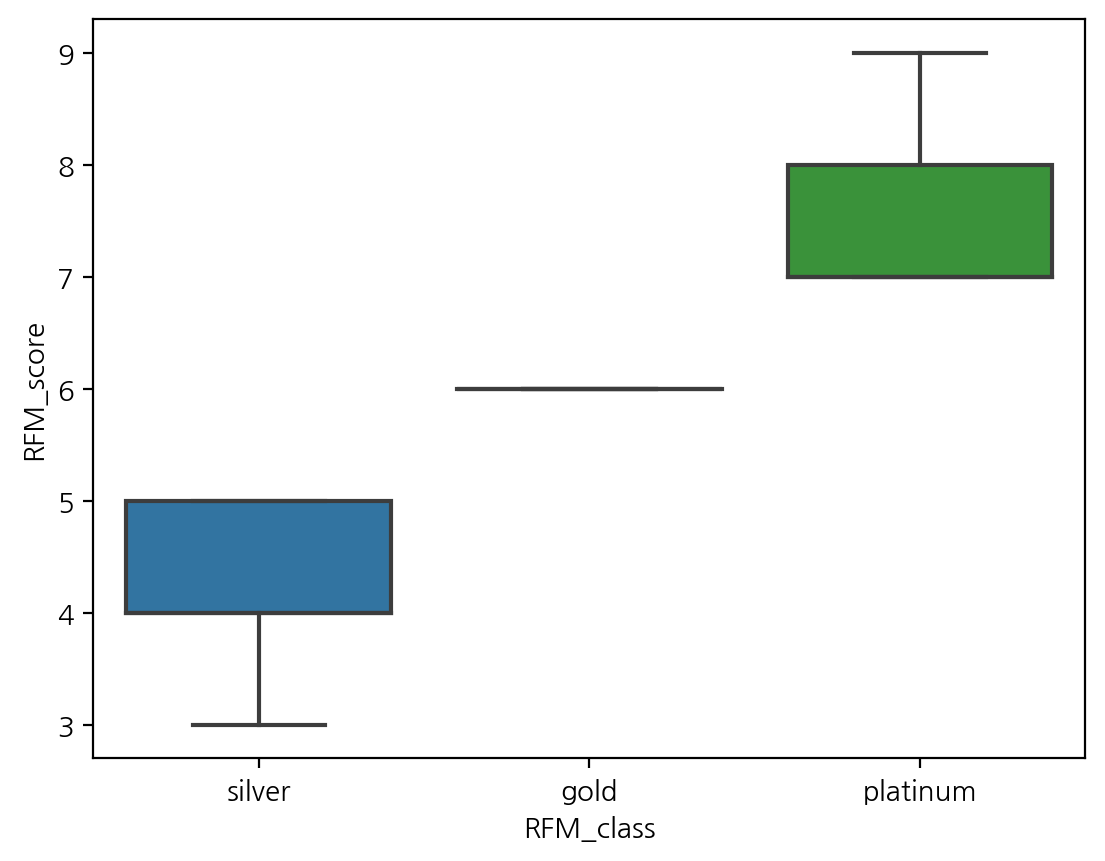

In [32]:
sns.boxplot(data=RFM, x="RFM_class", y="RFM_score")